# ResNet34 - Second Stage - Missing vs Present

Adapted from fast.ai's Deep Learning for Coders Notebook: `https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb` and the AWS version

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

## Looking at the ROI Images Data

In [4]:
path = Path(r'/home/ec2-user/SageMaker/classify-streetview/images-missing-present-2split')
path

PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-missing-present-2split')

In [5]:
path.ls()

[PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-missing-present-2split/train'),
 PosixPath('/home/ec2-user/SageMaker/classify-streetview/images-missing-present-2split/valid')]

In [6]:
# Transforms applied 
tfms = get_transforms(do_flip=False)

In [7]:


# https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder
data = ImageDataBunch.from_folder(path, ds_tfms = tfms, size = 224,   bs=bs).normalize()
data.classes


['0_missing', '1_present']

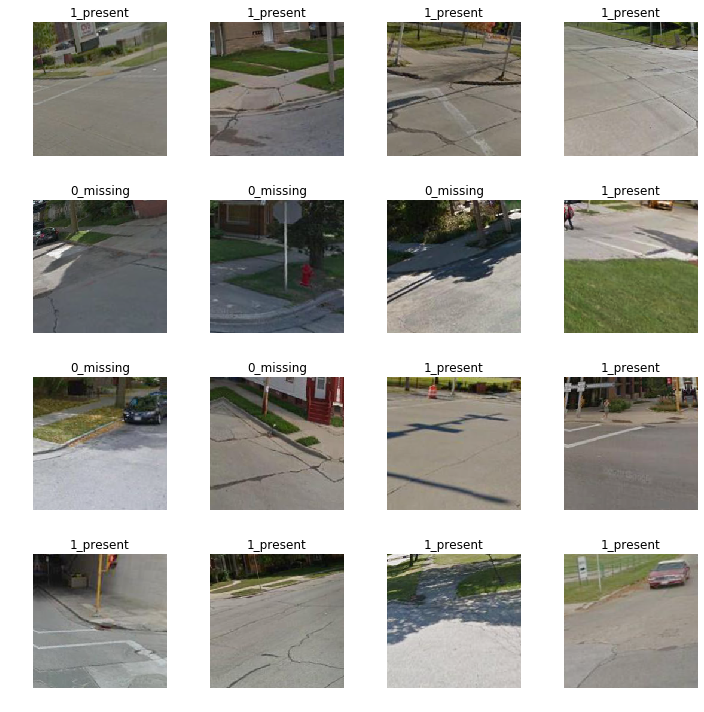

In [8]:
data.show_batch(rows=4, figsize=(10, 10))

In [9]:
print(data.classes)
len(data.classes),data.c

['0_missing', '1_present']


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [25]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, Precision(pos_label = 0)])

In [26]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [27]:
# Just train the fully connected layers for determining the class
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,precision,time
0,1.295763,1.440217,0.697329,0.097656,00:06
1,1.123390,0.665296,0.287834,0.130435,00:06
2,1.043144,0.547966,0.249258,0.142857,00:06
3,0.943696,0.555861,0.255193,0.139241,00:06


In [13]:
learn.save('stage1-4epochs')

## Results - On Validation Set

### To use the Test Set (assume no labels on test set...) 
https://forums.fast.ai/t/calculating-the-accuracy-for-test-set/39360/5

* Basically, make a new data bunch where valid is the desired test set

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

#len(data.valid_ds)==len(losses)==len(idxs)

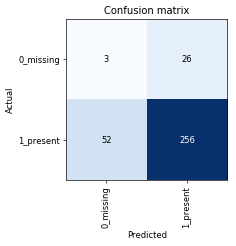

In [15]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

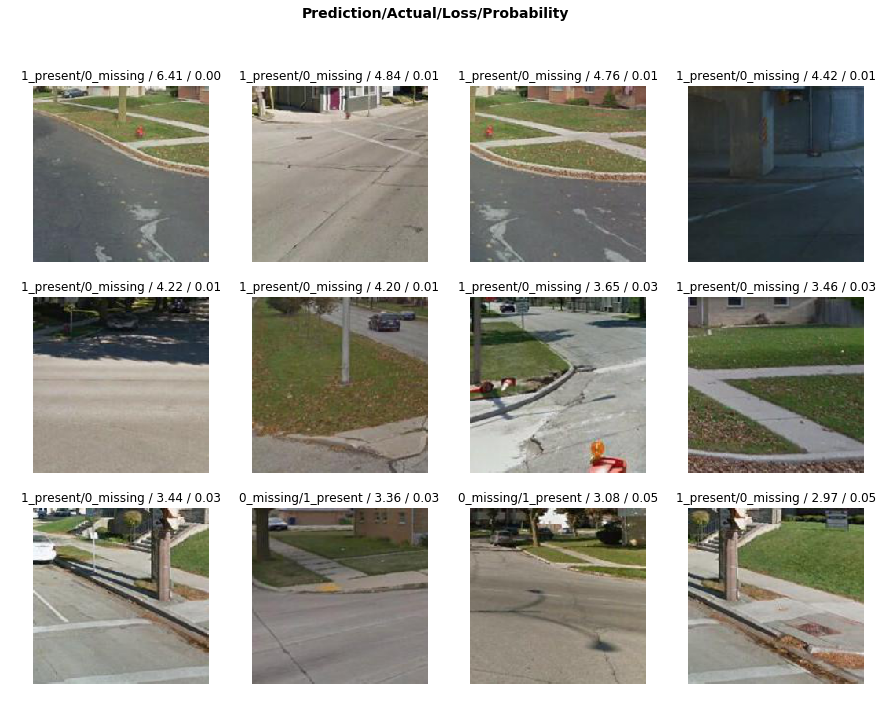

In [16]:
# Worst Predictions
interp.plot_top_losses(12, figsize=(15,11))

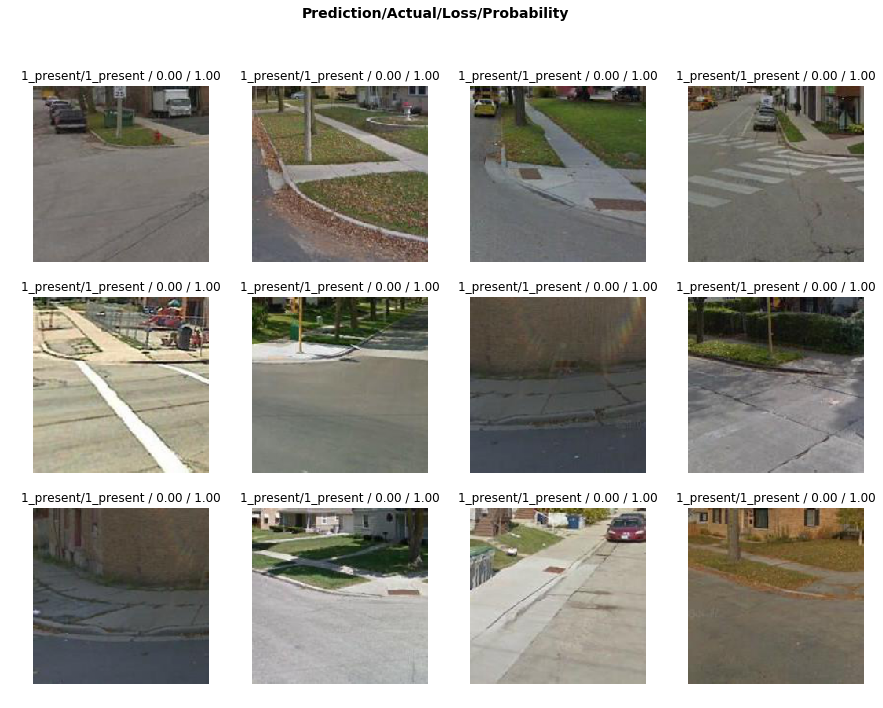

In [17]:
# Look at the best predictions! 
interp.plot_top_losses(12, largest = False, figsize=(15,11))

# Write out the Test Results

In [20]:
# https://docs.fast.ai/tutorial.inference.html
preds,y = learn.get_preds()

In [83]:
df_preds = pd.DataFrame(preds.tolist())
df_preds.columns = ['0_missing', '1_null', '2_present']
df_preds['y'] = pd.Series(y.tolist())
filepaths = list(data.items)
df_preds = filepaths
df_preds.head()

,missing,null,present
0,0.014393,0.503847,0.481760
1,0.035559,0.494790,0.469651
2,0.030482,0.194128,0.775389
3,0.032907,0.290189,0.676904
4,0.005965,0.319602,0.674434


In [81]:
num = len(learn.data.test_ds)

for i in range(num):
  filename = str(learn.data.test_ds.items[i]).split('/')[-1]
  learn.predict(learn.data.test_ds[i][0])

TypeError: object of type 'NoneType' has no len()

In [84]:
df_preds.head()

,missing,null,present,y
0,0.014393,0.503847,0.481760,2
1,0.035559,0.494790,0.469651,2
2,0.030482,0.194128,0.775389,2
3,0.032907,0.290189,0.676904,2
4,0.005965,0.319602,0.674434,2


array([PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/3_present/18810_135_5.jpg'),
       PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/3_present/6343_315_3.jpg'),
       PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/3_present/18998_135_6.jpg'),
       PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/3_present/10039_45_6.jpg'), ...,
       PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/1_null/17002_135_5.jpg'),
       PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/1_null/13198_225_2.jpg'),
       PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/1_null/1894_45_5.jpg'),
       PosixPath('/home/ec2-user/SageMaker/classify-streetview/images/train/1_null/6523_315_3.jpg')], dtype=object)

In [85]:
df_preds.to_csv('3class-probs-with-y.csv', index = False)

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


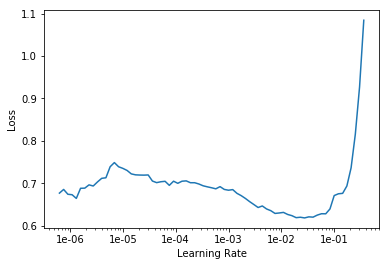

In [19]:
learn.recorder.plot()

In [20]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.810652,0.719274,0.201780,00:09
1,0.839491,13.519511,0.902077,00:08
2,0.765593,2.019916,0.382789,00:08
3,0.642777,0.783977,0.255193,00:08


In [21]:
learn.save('varlr-missing-present')

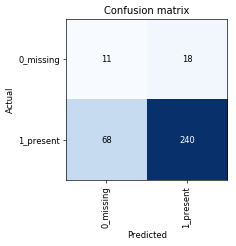

In [22]:
interp_unfreeze = ClassificationInterpretation.from_learner(learn)
interp_unfreeze.plot_confusion_matrix(figsize=(4,4), dpi=60)

In [25]:
(254 + 334) / (254 + 82 + 66 + 334)

0.7989130434782609

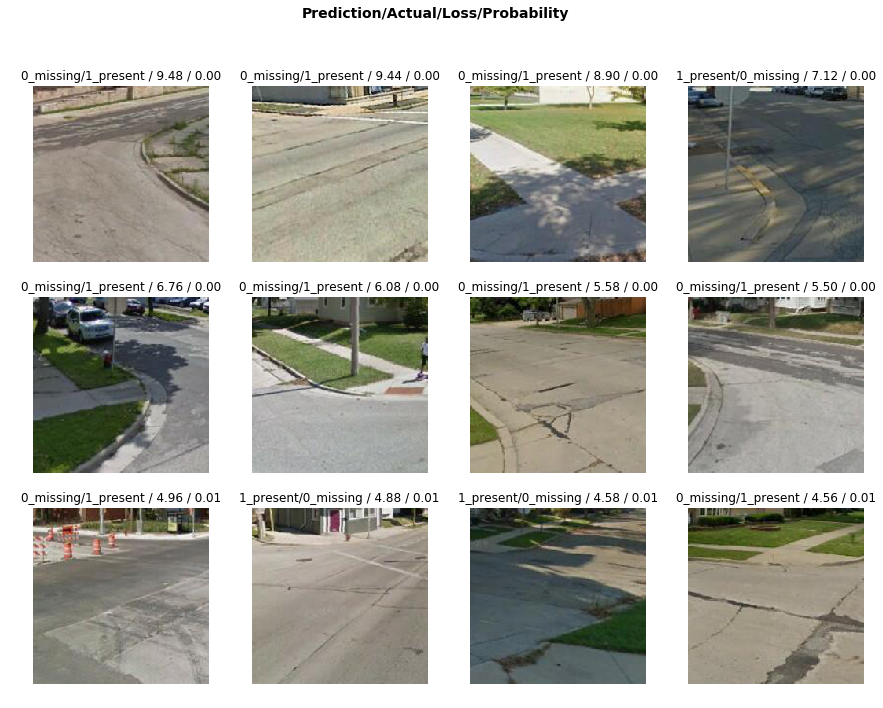

In [23]:
interp_unfreeze.plot_top_losses(12, figsize=(15,11))

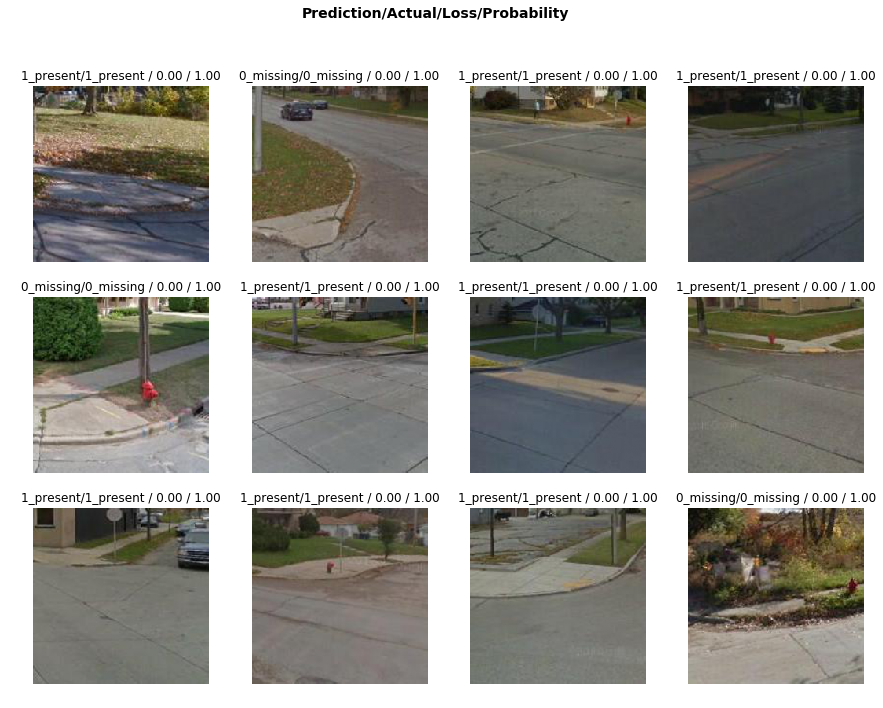

In [24]:
interp_unfreeze.plot_top_losses(12, largest = False, figsize=(15,11))